As the Anza Borrego file, but with Serpentine

In [2]:
import dd_functions as dd
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
# Read in data
spd = pd.read_csv('data/Serpentine.csv',dtype='Int64')
n0i = spd.sum().astype('Int64')
s0 = len(spd.columns)
n0 = n0i.sum()

In [4]:
# We already have the explicit bisection data so just create the fraction data
fr = dd.create_f(spd.T,thresh=128) # I should set the threshold to at least be ABLE to have one individual per cell
# Get unique species list
spl = fr['sp'].unique()

## Aggregate

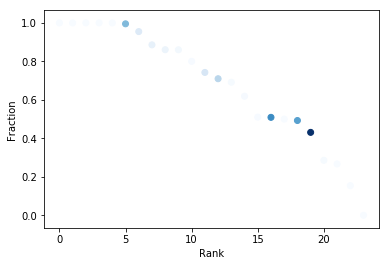

In [5]:
# Plot the aggregate
# First find the ni's
full_fr = (spd[0:128].sum()/n0i)
full_args = np.argsort(full_fr)[::-1]
plt.scatter(np.arange(len(full_fr)),full_fr.sort_values(ascending=False),c=n0i[full_args],cmap=plt.get_cmap('Blues'))
plt.ylabel('Fraction')
plt.xlabel('Rank')
plt.show()

In [6]:
# Now for each one get the preferred alpha value
# HOWEVER we need to be careful to not get infinite log likelihood, so our bounds are TIGHT
al_ag = minimize_scalar(dd.loglikelihood,bounds=(0.9,1.1),method='bounded',
                args=(spd[0:128].sum().values.astype(int),n0i))

In [7]:
# Basically prefers METE
al_ag

     fun: 114.55677203242222
 message: 'Solution found.'
    nfev: 19
  status: 0
 success: True
       x: 1.000307007635585

In [8]:
# Compare likelihoods:
# Density dependent
print(dd.loglikelihood(al_ag.x,spd[0:128].sum().values.astype(int),n0i))
# METE
print(-np.sum(np.log(1/(n0i+1))))
# Random Placement
print(-np.sum(st.binom.logpmf(spd[0:128].sum().astype(int), n0i.astype(int), 0.5)))
# Can get deviance as |mete-density dependent|*2, then use this as the argument for a chi^2 distribution
# with one extra parameter (k=1). Then 1-CDF gives a p-value. CDF is special funcion, just use mathematica.
print("p-value: {:.3f}".format(
  1-st.chi2.cdf(2*(-np.sum(np.log(1/(n0i+1)))-dd.loglikelihood(al_ag.x,spd[0:128].sum().values.astype(int),n0i)),1)))

114.55677203242222
114.84688115523167
5188.5652342625945
p-value: 0.446


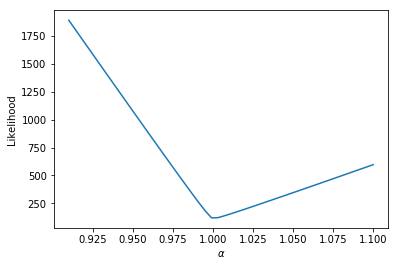

In [9]:
# To show that the tight bounds are ok, here is the likelihood function:
atl=np.linspace(0.91,1.1)
ll = []
for at in atl:
    ll.append(dd.loglikelihood(at,spd[0:128].sum().values.astype(int),n0i))
plt.plot(atl,ll)
plt.xlabel(r'$\alpha$')
plt.ylabel('Likelihood')
plt.show()

In [7]:
# Get contour intervals
pc=0.05
nmax = max(n0i)
logrange,dda_int = dd.contours(al_ag.x,pc,nmax)
# Set up arrays for other distributions
bi_int = []
mete_int = []
for n in logrange:
    bi_int_t = st.binom.interval(1-pc,n,0.5)
    bi_int.append((bi_int_t[0]/n,bi_int_t[1]/n))
    mete_int.append((np.floor(pc/2*(n+1))/(n+1),np.ceil((1-pc/2)*(n+1))/(n+1)))

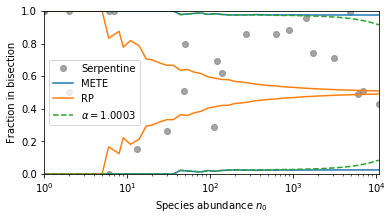

In [8]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(6,3))
colors = plt.get_cmap("tab10")
# Plot with abundance on x instead of rank ordering
sptp = ax.semilogx(np.array(n0i.values),full_fr.values,'o',c=colors(7),alpha=0.7,label='Serpentine')
metep = ax.semilogx(logrange,mete_int,c=colors(0),label='METE')
bip = ax.semilogx(logrange,bi_int,c=colors(1),label='RP')
alp = ax.semilogx(logrange,dda_int,'--',c=colors(2),label=r'$\alpha={:.4f}$'.format(al_ag.x))
ax.legend((sptp[0],metep[0],bip[0],alp[0]),('Serpentine','METE','RP',r'$\alpha={:.4f}$'.format(al_ag.x)))
ax.set_ylim(0,1)
ax.set_xlim(1,nmax)
ax.set_ylabel('Fraction in bisection')
ax.set_xlabel(r'Species abundance $n_0$')
plt.savefig('Contours_Serpentine.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Manuscript/Contours_Serpentine.eps',format='eps',bbox_inches='tight')
plt.savefig('Manuscript/Contours_Serpentine.pdf',format='pdf',bbox_inches='tight')

In [13]:
# What about aggregate but at the finer scale?
al_ag_fine = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(fr['frac']*fr['n0']).astype(int),fr['n0']))

In [14]:
al_ag_fine

     fun: 2498.261378199807
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 1.1454458966607557

## What scale does $\alpha$ change at?
At 16x16, we see $\alpha=1.15$, but it agrees perfectly with METE at bisection level.

In [12]:
inds = (spd.index//32*8+spd.index//2%8) # I think this is taking the nearest 4 cells and summing them together
# That SHOULD result in a grid that is now 8x8
fr88 = dd.create_f(spd.groupby(inds).sum().T,thresh=128)

In [13]:
# Now make a fraction at 8x16 instead of 16x16, so sum adjacent plots then compare.
fr816 = dd.create_f(spd.groupby(spd.index//2).sum().T,thresh=128)

In [14]:
# Really I also want a point that is just divided in 4 to have one point closer to the bisection
inds = (spd.index//128*2+spd.index//8%2)
fr22 = dd.create_f(spd.groupby(inds).sum().T,thresh=128)

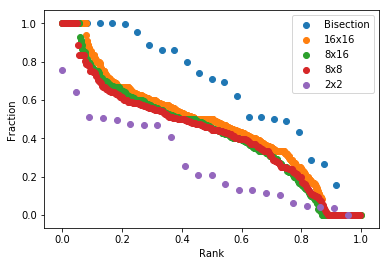

In [132]:
# Plot the rank ordered bisections for each scale
# Scale x-axis by highest rank
plt.scatter(np.arange(len(full_fr))/len(full_fr),full_fr.sort_values(ascending=False),label='Bisection')
plt.scatter(np.arange(len(fr))/len(fr),fr['frac'].sort_values(ascending=False),label='16x16')
plt.scatter(np.arange(len(fr816))/len(fr816),fr816['frac'].sort_values(ascending=False),label='8x16')
plt.scatter(np.arange(len(fr88))/len(fr88),fr88['frac'].sort_values(ascending=False),label='8x8')
plt.scatter(np.arange(len(fr22))/len(fr22),fr22['frac'].sort_values(ascending=False),label='2x2')
plt.ylabel('Fraction')
plt.xlabel('Rank')
plt.legend()
plt.show()

In [15]:
# Now aggregate at this scale
al_ag_816 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(fr816['frac']*fr816['n0']).astype(int),fr816['n0']))

In [16]:
al_ag_816

     fun: 1665.313716441459
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 1.0464744935091157

In [17]:
# Now aggregate at this scale
al_ag_88 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(fr88['frac']*fr88['n0']).astype(int),fr88['n0']))

In [18]:
al_ag_88

     fun: 1006.2577585818034
 message: 'Solution found.'
    nfev: 12
  status: 0
 success: True
       x: 1.032927327325396

In [19]:
# Now aggregate at this scale
al_ag_22 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                args=(np.rint(fr22['frac']*fr22['n0']).astype(int),fr22['n0']))

In [20]:
al_ag_22

     fun: 139.60027930993218
 message: 'Solution found.'
    nfev: 18
  status: 0
 success: True
       x: 1.0004231864181838

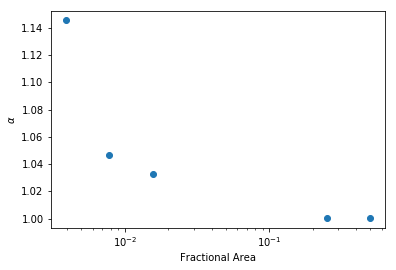

In [139]:
# Plot area versus alpha
plt.semilogx([1.0/2,1.0/4,1.0/64,1.0/128,1.0/256],[al_ag.x,al_ag_22.x,al_ag_88.x,al_ag_816.x,al_ag_fine.x],'o')
plt.xlabel('Fractional Area')
plt.ylabel(r'$\alpha$')
plt.show()

## Individual species

In [21]:
# Now for each one get the preferred alpha value
al = []
nn = []
for sp in spl:
    args = fr['sp']==sp
    sol = minimize_scalar(dd.loglikelihood,bounds=(0.8,4.),method='bounded',
                args=(np.rint(fr[args]['frac']*fr[args]['n0']).astype(int),fr[args]['n0']))
    al.append(sol.x)
    nn.append(n0i[sp])
df_al = pd.DataFrame({'alphas': al,'n0':nn},index=spl)

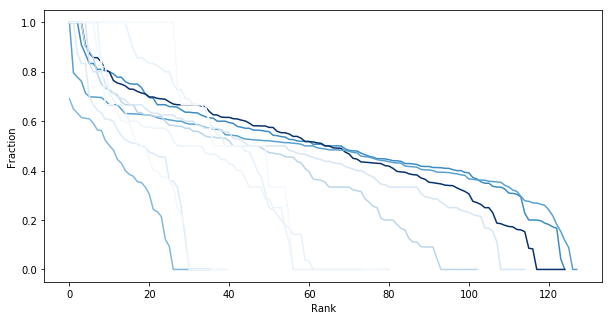

In [22]:
# Plot all the species
fig,ax = plt.subplots(figsize=(10,5))
colors = cm.get_cmap('Blues')
for sp in spl:
    ax.plot(fr['frac'][fr['sp']==sp].sort_values(ascending=False).values,
            label=r'{}, $\alpha$={:.2f}'.format(sp,df_al.loc[sp][0]), c=colors(n0i[sp]/n0i.max()))

#ax.legend()
ax.set_xlabel('Rank')
ax.set_ylabel('Fraction')
plt.show()

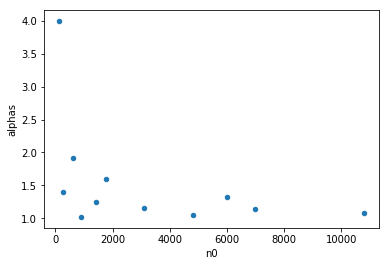

In [23]:
# Does alpha vary with abundance?
#fig,ax = plt.subplots(figsize=(10,5))
df_al.plot(x='n0',y='alphas',kind='scatter')
#for sp in spl:
#    ax.scatter(n0i[sp],df_al['alphas'].loc[sp])
#plt.set_xlabel('Abundance')
#plt.set_ylabel(r'$\alpha$')
#plt.show()

In [24]:
# Why is 'EN' so weird?
args = fr['sp']=='EN'
sol = minimize_scalar(dd.loglikelihood,bounds=(4.,8.),method='bounded',
            args=(np.rint(fr[args]['frac']*fr[args]['n0']).astype(int),fr[args]['n0']))
sol.x

6.380658426035434

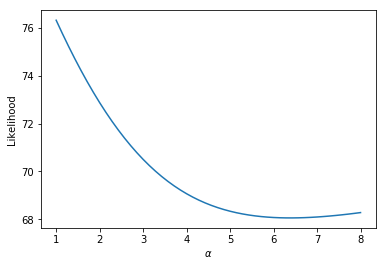

In [25]:
# To show that the tight bounds are ok, here is the likelihood function:
atl=np.linspace(1,8)
ll = []
args = fr['sp']=='EN'
for at in atl:
    ll.append(dd.loglikelihood(at,np.rint(fr[args]['frac']*fr[args]['n0']).astype(int),fr[args]['n0']))
plt.plot(atl,ll)
plt.xlabel(r'$\alpha$')
plt.ylabel('Likelihood')
plt.show()

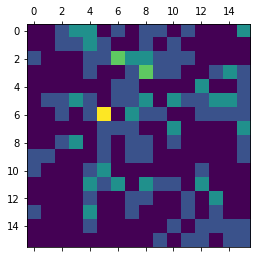

In [26]:
# Keep this as a neat way to show the plot, but also to see why 'EN' is so weird.
plt.matshow(np.array(spd['EN'].values,dtype='float').reshape(16,16))

# Individual species at different scales

In [27]:
# Create fractions
# Keep threshold at 128 everywhere
th = 128
# Divide into 2x2
inds4 = (spd.index//128*2+spd.index//8%2)
sfr4 = dd.create_f(spd.groupby(inds4).sum().T,thresh=th)
# Divide into 2x4
inds8 = (spd.index//64*2+spd.index//8%2)
sfr8 = dd.create_f(spd.groupby(inds8).sum().T,thresh=th)
# Divide into 4x4
inds16 = (spd.index//64*4+spd.index//4%4)
sfr16 = dd.create_f(spd.groupby(inds16).sum().T,thresh=th)
# Divide into 4x8
inds32 = (spd.index//32*4+spd.index//4%4)
sfr32 = dd.create_f(spd.groupby(inds32).sum().T,thresh=th)
# Divide into 8x8
inds64 = (spd.index//32*8+spd.index//2%8) # I think this is taking the nearest 4 cells and summing them together
sfr64 = dd.create_f(spd.groupby(inds64).sum().T,thresh=th)
# Divide into 8x16, so sum adjacent plots then compare.
sfr128 = dd.create_f(spd.groupby(spd.index//2).sum().T,thresh=th)
# Divide into 16x16
sfr256 = dd.create_f(spd.T,thresh=th)

In [28]:
# Start at 2x4, which is 3 points.
sp_al = np.zeros([len(spl),6]) # six is the number of scales
# For every species, get alpha at each scale.
for i,sp in enumerate(spl):
    # 2x4
    sal8 = minimize_scalar(dd.loglikelihood,bounds=(0.8,1.5),method='bounded',
                    args=(np.rint(sfr8[sfr8['sp']==sp]['frac']*sfr8[sfr8['sp']==sp]['n0']).astype(int),
                          sfr8[sfr8['sp']==sp]['n0']))
    # 4x4
    sal16 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr16[sfr16['sp']==sp]['frac']*sfr16[sfr16['sp']==sp]['n0']).astype(int),
                          sfr16[sfr16['sp']==sp]['n0']))
    # 4x8
    sal32 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr32[sfr32['sp']==sp]['frac']*sfr32[sfr32['sp']==sp]['n0']).astype(int),
                          sfr32[sfr32['sp']==sp]['n0']))
    # 8x8
    sal64 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr64[sfr64['sp']==sp]['frac']*sfr64[sfr64['sp']==sp]['n0']).astype(int),
                          sfr64[sfr64['sp']==sp]['n0']))
    # 8x16
    sal128 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr128[sfr128['sp']==sp]['frac']*sfr128[sfr128['sp']==sp]['n0']).astype(int),
                          sfr128[sfr128['sp']==sp]['n0']))
    # 16x16
    sal256 = minimize_scalar(dd.loglikelihood,bounds=(0.8,2.),method='bounded',
                    args=(np.rint(sfr256[sfr256['sp']==sp]['frac']*sfr256[sfr256['sp']==sp]['n0']).astype(int),
                          sfr256[sfr256['sp']==sp]['n0']))
    sp_al[i,:] = [sal8.x,sal16.x,sal32.x,sal64.x,sal128.x,sal256.x]

In [29]:
frac_a =[1/2**n for n in np.arange(3,9)] 
df_c = pd.DataFrame(sp_al,index=spl,columns = np.log2(frac_a))

In [168]:
# Don't plot 'EN' in the next few:

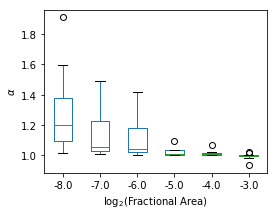

In [30]:
fig,ax=plt.subplots(figsize=(4,3))
df_c.drop('EN').iloc[:, ::-1].plot(ax=ax,kind='box')
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\log_2$(Fractional Area)')
plt.savefig('alphaBoxSerpentine.pdf',format='pdf',bbox_inches='tight')
plt.savefig('Manuscript/alphaBoxSerpentine.pdf',format='pdf',bbox_inches='tight')

Text(0.5,0,'$\\log_2$(Fractional Area)')

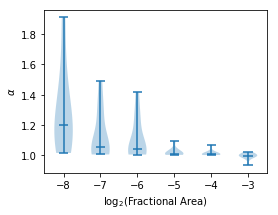

In [31]:
# Change columns to fractional area instead of number of cells
fig,ax=plt.subplots(figsize=(4,3))
ax.violinplot(dataset= [df_c.drop('EN')[-8],df_c.drop('EN')[-7],df_c.drop('EN')[-6],df_c.drop('EN')[-5],
                        df_c[-4].drop('EN'),df_c.drop('EN')[-3]],positions = np.log2(frac_a[::-1]),
             showmedians=True,showextrema=True)
#df_c.plot(ax=ax,kind='box')
ax.set_ylabel(r'$\alpha$')
ax.set_xlabel(r'$\log_2$(Fractional Area)')
#plt.savefig('alphaVioSerpentine.pdf',format='pdf',bbox_inches='tight')
#plt.savefig('Manuscript/alphaVioSerpentine.pdf',format='pdf',bbox_inches='tight')

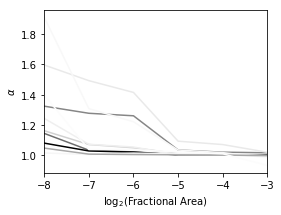

In [35]:
# All of them!
fig,ax=plt.subplots(figsize=(4,3))
colors = cm.get_cmap('Greys')#'Blues')
n0max = max(n0i)
for sp in spl:
    if sp != 'EN':
        df_c.loc[sp].T.plot(ax=ax,c=colors(n0i[sp]/n0max),label=sp)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)
ax.legend(ncol=2)
#ax.set_ylim(0.9,2)
ax.set_xlabel(r'$\log_2$(Fractional Area)')
ax.set_ylabel(r'$\alpha$')
plt.savefig('alphaScaleAllSpeciesSerpentine.pdf',bbox_inches='tight')
plt.savefig('Manuscript/alphaScaleAllSpeciesSerpentine.pdf',format='pdf',bbox_inches='tight')
ax.get_legend().remove()
plt.savefig('alphaScaleAllSpeciesSerpentine_nolegend.pdf',bbox_inches='tight')
plt.savefig('Manuscript/alphaScaleAllSpeciesSerpentine_nolegend.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [232]:
# Which are on average high and on average low?
df_c.mean(axis=1).sort_values()

BH     1.008767
PE     1.010286
VM     1.022378
BM     1.034895
CP     1.049477
MD2    1.061240
MD1    1.072981
AS     1.155435
GS     1.245956
UT     1.280827
EN     1.718832
dtype: float64

In [236]:
# Formal outlier detection
q1, q3= np.percentile(df_c.mean(axis=1).sort_values(),[25,75])
iqr = q3-q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
print('lower: {:.3f}, upper: {:.3f}'.format(lower_bound,upper_bound))

lower: 0.771, upper: 1.459


So EN, GS, UT, and AS are by eye kind of high, the rest are all very similar. Formally only EN is an outlier.

EN is Eriogonum nudum, a plant with a very large canopy compared to others at the grassland site. It makes sense why it would be overdispersed.

GS is Gilia sinistra, UT is unidentified tarweed, and AS is Allium Serra.

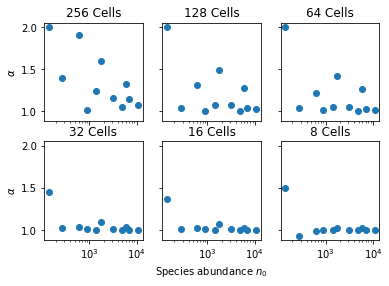

In [187]:
# Got abundances above for plot with a few of the most abundant on it.
# Ignore top left point as it's the weird EN point.
fig,axes = plt.subplots(nrows=2,ncols=3,sharey=True,sharex=True)
axes[0,0].semilogx(np.array(n0i.loc[df_c[-8].dropna().index]),df_c[-8].dropna().values,'o')
axes[0,1].semilogx(np.array(n0i.loc[df_c[-7].dropna().index]),df_c[-7].dropna().values,'o')
axes[0,2].semilogx(np.array(n0i.loc[df_c[-6].dropna().index]),df_c[-6].dropna().values,'o')
axes[1,0].semilogx(np.array(n0i.loc[df_c[-5].dropna().index]),df_c[-5].dropna().values,'o')
axes[1,1].semilogx(np.array(n0i.loc[df_c[-4].dropna().index]),df_c[-4].dropna().values,'o')
axes[1,2].semilogx(np.array(n0i.loc[df_c[-3].dropna().index]),df_c[-3].dropna().values,'o')

axes[0,0].set_title('256 Cells')
axes[0,1].set_title('128 Cells')
axes[0,2].set_title('64 Cells')
axes[1,0].set_title('32 Cells')
axes[1,1].set_title('16 Cells')
axes[1,2].set_title('8 Cells')

#for a in axes[1,:]:
#    a.set_xlabel(r'Species abundance $n_0$')
axes[1,1].set_xlabel(r'Species abundance $n_0$')

for a in axes[:,0]:
    a.set_ylabel(r'$\alpha$')
    
#plt.savefig('abundanceSerpentine.pdf',format='pdf',bbox_inches='tight')
#plt.savefig('Manuscript/appendix_abundanceSerpentine.pdf',format='pdf',bbox_inches='tight')

# Other

In [23]:
# Get contours
# Note these are somewhat misleading since my claim is that different species have different alphas
logr, cont = dd.contours(al_ag_fine.x,0.05,fr['n0'].max())

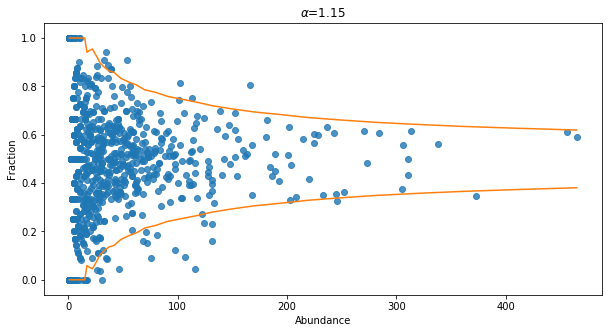

In [25]:
# Now plot these contour intervals
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(fr['n0'],fr['frac'],alpha=0.8)
ax.plot(logr,cont,c='C1')
ax.set_xlabel('Abundance')
ax.set_ylabel('Fraction')
ax.set_title(r'$\alpha$={:.2f}'.format(al_ag_fine.x))
plt.show()